# AuNR DA Figure 2

In [1]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression

%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

# input data

In [2]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data = glass_data.drop(['corrcoef'], axis=1)
glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

# further control the dataset so that all aspect ratio in glass can fall into the range of ITO's ratio
ito_ratio_min = ito_data['ratio'].min()
ito_ratio_max = ito_data['ratio'].max()

glass_data = glass_data[(glass_data['ratio'] > ito_ratio_min) & (glass_data['ratio'] < ito_ratio_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# further control the dataset so that all width and length in glass can fal into the range of ITO's
ito_width_min = ito_data['width'].min()
ito_width_max = ito_data['width'].max()
ito_length_min = ito_data['length'].min()
ito_length_max = ito_data['length'].max()

ito_data = ito_data[ito_data['ratio'] <= 4.4]

glass_data = glass_data[(glass_data['width'] > ito_width_min) & (glass_data['width'] < ito_width_max)]
glass_data = glass_data[(glass_data['length'] > ito_length_min) & (glass_data['length'] < ito_length_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# Randomly sample 1000 rows from each dataframe
glass_data = glass_data.sample(n=1000, random_state=42)
glass_data = glass_data.reset_index(drop=True)
ito_data = ito_data.sample(n=1000, random_state=42)
ito_data = ito_data.reset_index(drop=True)
print(glass_data.shape)

(1205, 7)
(1179, 7)
(1000, 7)


In [3]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    dEres_IG = Eres_ito - Eres_glass
    return dEres_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.97
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG = calc_dif(idx, ito_data, glass_data)
        if dEres_IG.shape == (1,): 
            dEres_IG_list.append(dEres_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    C = dEres_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    return target_Eres

In [4]:
ITO_nsub = 1.97
ITO_Eres = numerical_method(ito_data, glass_data, target_nsub=ITO_nsub)

In [7]:
def get_sub(x): 
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s)) 
    return x.translate(res) 

In [8]:
print('E{}'.format(get_sub('res')))

Eᵣₑₛ


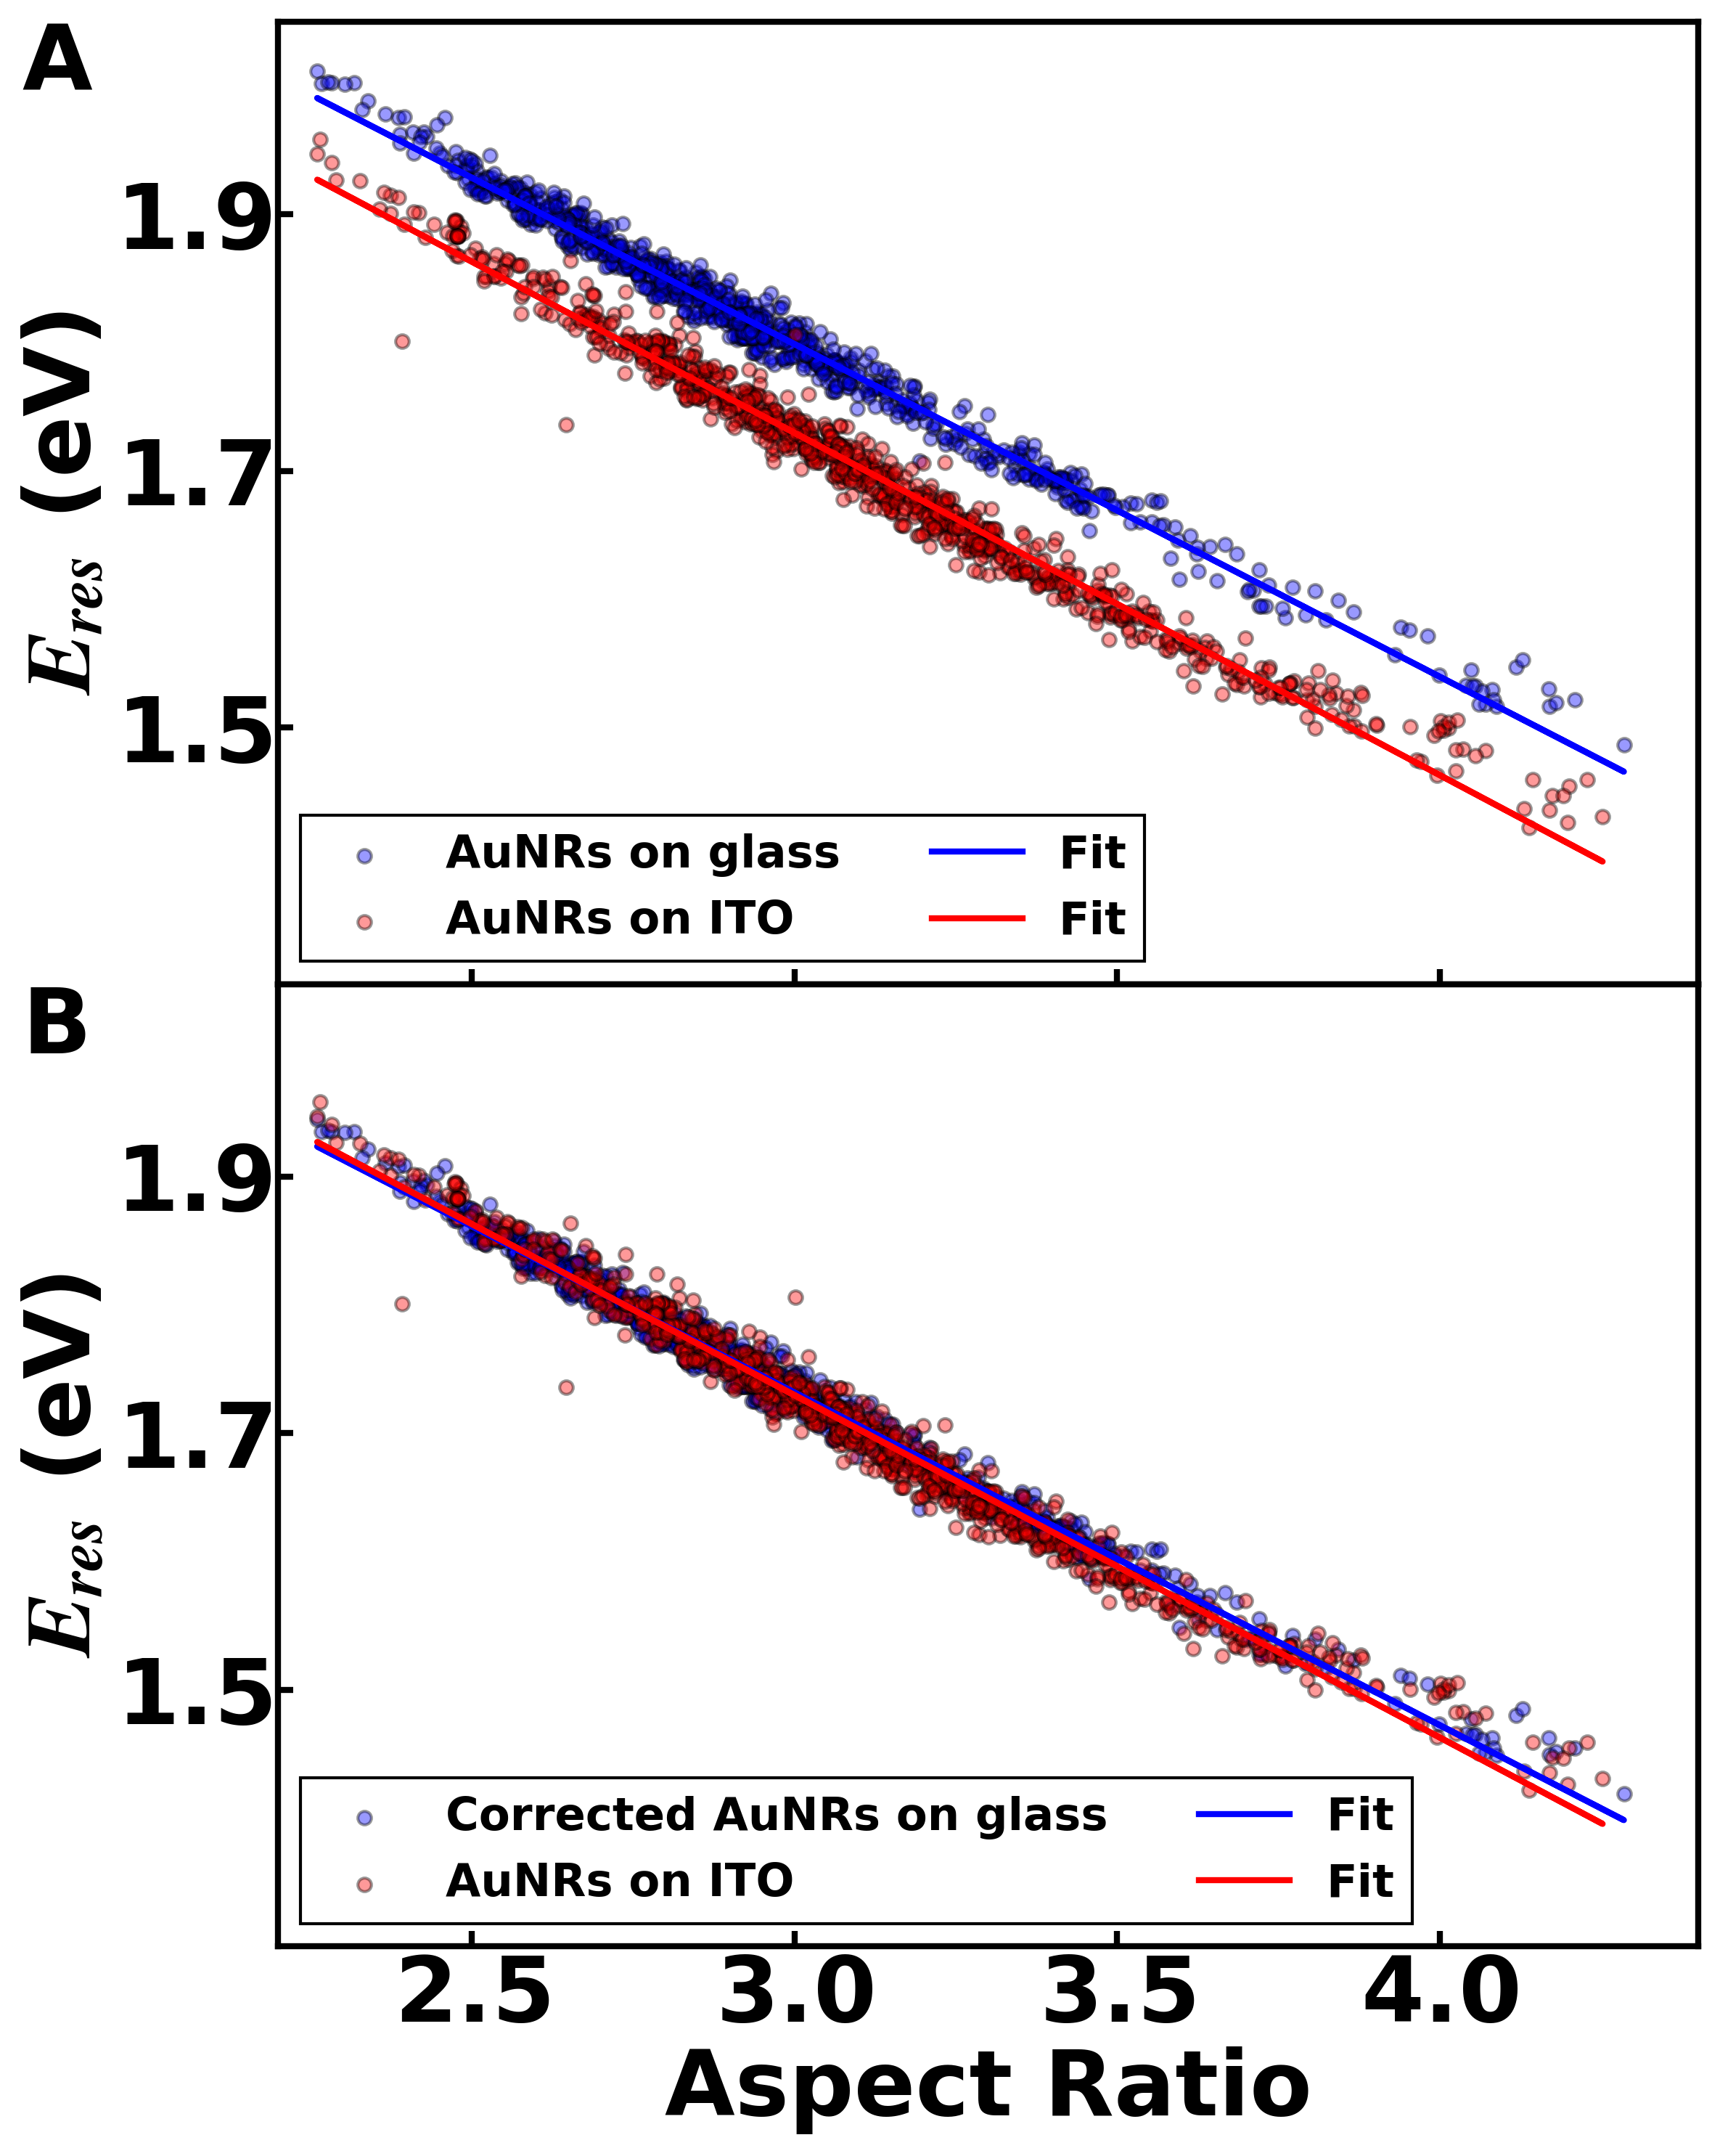

In [5]:
# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10), gridspec_kw={'hspace': 0}, dpi=300)
# plt.rcParams['font.family'] = 'Arial' 

# Perform linear regression
model1 = LinearRegression()
model1.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres'])
slope1, intercept1 = model1.coef_[0], model1.intercept_

model2 = LinearRegression()
model2.fit(ito_data['ratio'].values.reshape(-1, 1), ito_data['eres'])
slope2, intercept2 = model2.coef_[0], model2.intercept_

ax1.scatter(glass_data['ratio'], glass_data['eres'], s=20, c='b', edgecolor='k', alpha=0.4, label='AuNRs on glass')
ax1.scatter(ito_data['ratio'], ito_data['eres'], s=20, c='r', edgecolor='k', alpha=0.4, label='AuNRs on ITO')
ax1.plot(glass_data['ratio'], slope1 * glass_data['ratio'] + intercept1, c='b', lw=2, label='Fit')
ax1.plot(ito_data['ratio'], slope2 * ito_data['ratio'] + intercept2, c='r', lw=2, label='Fit')
ax1.set_ylabel('$E_{res}$ (eV)', fontsize=30)
ax1.set_yticks([1.5, 1.7, 1.9])
ax1.set_xlim(2.2, 4.4)
ax1.set_ylim(1.3, 2.05)
ax1.tick_params(axis='y', labelsize=30, pad=2)
ax1.legend(loc='lower left', fontsize=15, ncols=2)
ax1.text(-0.18, 1, 'A', ha='left', va='top', transform=ax1.transAxes, fontsize=30)

# Perform linear regression
model3 = LinearRegression()
model3.fit(glass_data['ratio'].values.reshape(-1, 1), ITO_Eres)
slope3, intercept3 = model3.coef_[0], model3.intercept_

ax2.scatter(glass_data['ratio'], ITO_Eres, s=20, c='b', edgecolor='k', alpha=0.4, label='Corrected AuNRs on glass')
ax2.scatter(ito_data['ratio'], ito_data['eres'], s=20, c='r', edgecolor='k', alpha=0.4, label='AuNRs on ITO')
ax2.plot(glass_data['ratio'], slope3 * glass_data['ratio'] + intercept3, c='b', lw=2, label='Fit')
ax2.plot(ito_data['ratio'], slope2 * ito_data['ratio'] + intercept2, c='r', lw=2, label='Fit')
ax2.set_xlabel('Aspect Ratio', fontsize=30)
ax2.set_ylabel('$E_{res}$ (eV)', fontsize=30)
ax2.set_xticks([2.5, 3.0, 3.5, 4.0])
ax2.set_yticks([1.5, 1.7, 1.9])
ax2.set_xlim(2.2, 4.4)
ax2.set_ylim(1.3, 2.05)
ax2.tick_params(axis='both', labelsize=30, pad=2)
ax2.legend(loc='lower left', fontsize=15, ncols=2)
ax2.text(-0.18, 1, 'B', ha='left', va='top', transform=ax2.transAxes, fontsize=30)

plt.subplots_adjust(hspace=0)

## Statistical Reasoning

In [20]:
import numpy as np
import pandas as pd

# Assuming corrected_eres is your numpy array containing the corrected 'eres' values for the glass data
glass_data['eres_corrected'] = ITO_Eres

# Add group labels to both datasets
glass_data['group'] = 'glass'
ito_data['group'] = 'ITO'

# Combine into one DataFrame for regression
# Ensure to use 'eres_corrected' for glass in Figure B analysis
combined_data_figure_b = pd.concat([
    glass_data[['ratio', 'eres_corrected', 'group']].rename(columns={'eres_corrected': 'eres'}),
    ito_data[['ratio', 'eres', 'group']]
])

# For Figure A, use the original 'eres'
combined_data_figure_a = pd.concat([
    glass_data[['ratio', 'eres', 'group']],
    ito_data[['ratio', 'eres', 'group']]
])

In [21]:
import statsmodels.api as sm

# Fit model for Figure A
model_a = sm.OLS.from_formula('eres ~ ratio * group', data=combined_data_figure_a).fit()

# Fit model for Figure B with corrected values
model_b = sm.OLS.from_formula('eres ~ ratio * group', data=combined_data_figure_b).fit()

# Output summaries
print("Model Summary for Figure A:")
print(model_a.summary())

print("\nModel Summary for Figure B:")
print(model_b.summary())


Model Summary for Figure A:
                            OLS Regression Results                            
Dep. Variable:                   eres   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 5.090e+04
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:36:49   Log-Likelihood:                 5962.6
No. Observations:                2000   AIC:                        -1.192e+04
Df Residuals:                    1996   BIC:                        -1.189e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Inte

In [8]:
# Assuming glass_data and ito_data are already defined with columns 'ratio' and 'eres'

# Add a substrate group column to each dataframe
glass_data['Group'] = 0  # Glass
ito_data['Group'] = 1    # ITO

# Combine the dataframes into a single dataframe
data = pd.concat([glass_data, ito_data], ignore_index=True)

# Calculate the interaction term needed for the combined regression model
data['Interaction'] = data['ratio'] * data['Group']

# Now you can use 'data' in the regression model


In [9]:
import statsmodels.api as sm

# Defining independent variables and adding a constant for the intercept
X = data[['ratio', 'Group', 'Interaction']]
X = sm.add_constant(X)

# Dependent variable
y = data['eres']

# Fitting the model
model = sm.OLS(y, X).fit()

# Printing the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   eres   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 5.090e+04
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:22:53   Log-Likelihood:                 5962.6
No. Observations:                2000   AIC:                        -1.192e+04
Df Residuals:                    1996   BIC:                        -1.189e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.5769      0.003    737.812      